make eos-curve structures.

In [ ]:
from wizard.atoms import SymbolInfo
from wizard.calculator import MaterialCalculator
from calorine.calculators import CPUNEP

calc = CPUNEP('../../potentials/4-4-80/nep.txt')

nep_coh = {}
symbol_infos = [
SymbolInfo('Ag', 'fcc', 4.146),
SymbolInfo('Al', 'fcc', 4.042),
SymbolInfo('Au', 'fcc', 4.159),
SymbolInfo('Cu', 'fcc', 3.631),
SymbolInfo('Ni', 'fcc', 3.509),
SymbolInfo('Pb', 'fcc', 5.038),
SymbolInfo('Pd', 'fcc', 3.939),
SymbolInfo('Pt', 'fcc', 3.967),
SymbolInfo('Cr', 'bcc', 2.845),
SymbolInfo('Mo', 'bcc', 3.164),
SymbolInfo('Ta', 'bcc', 3.319),
SymbolInfo('V',  'bcc', 2.997),
SymbolInfo('W',  'bcc', 3.185),
SymbolInfo('Mg', 'hcp', 3.195, 5.186),
SymbolInfo('Ti', 'hcp', 2.931, 4.651),
SymbolInfo('Zr', 'hcp', 3.240, 5.157)
]

for symbol_info in symbol_infos:
    atoms = symbol_info.create_bulk_atoms((1,1,1))
    material_calculator = MaterialCalculator(atoms, calc, symbol_info)
    material_calculator.eos_curve()

Get DFT results.

In [2]:
from wizard.io import read_xyz
import json

symbols = ['Ag', 'Al', 'Au', 'Cu', 'Ni', 'Pb', 'Pd', 'Pt', 'Cr', 'Mo', 'Ta', 'V', 'W', 'Mg', 'Ti', 'Zr']
coh = {'DFT':{'Ag': -2.71005475, 'Al': -3.74973925, 'Au': -3.19144525, 'Cr': -9.4968225, 'Cu': -3.7289355, 'Mg': -1.5052285, 'Mo': -10.9338395, 'Ni': -5.413272, 'Pb': -3.54437875, 'Pd': -5.2096485, 'Pt': -6.0847035, 'Ta': -11.8113015, 'Ti': -7.833308, 'V': -8.9860585, 'W': -12.949979, 'Zr': -8.517786},
       'NEP':{'Ag': -2.7156729538954725, 'Al': -3.7415023383871455, 'Au': -3.22694901955475, 'Cu': -3.724303163438888, 'Ni': -5.418106583077931, 'Pb': -3.556323614530033, 'Pd': -5.2191480833336605, 'Pt': -6.096431278308883, 'Cr': -9.520702301334984, 'Mo': -10.939805417343191, 'Ta': -11.819861108235346, 'V': -9.004549586726789, 'W': -12.957658300138636, 'Mg': -1.5063760093485516, 'Ti': -7.831068928483184, 'Zr': -8.512153230979079}}

data = {symbol: {'volume': [], 'DFT': [], 'NEP': []} for symbol in symbols}
frames = read_xyz('ref.xyz')
for atoms in frames:
    symbol = set(atoms.get_chemical_symbols()).pop()
    data[symbol]['volume'].append(atoms.get_volume() / len(atoms))
    data[symbol]['DFT'].append(atoms.info['energy'] / len(atoms) - coh['DFT'][symbol])
    
with open('data.json', 'w') as f:
       json.dump(data, f)

Get NEP results.

In [3]:
from calorine.calculators import CPUNEP
from wizard.io import read_xyz
import json

with open('data.json', 'r') as f:
       data = json.load(f)

coh = {'DFT':{'Ag': -2.71005475, 'Al': -3.74973925, 'Au': -3.19144525, 'Cr': -9.4968225, 'Cu': -3.7289355, 'Mg': -1.5052285, 'Mo': -10.9338395, 'Ni': -5.413272, 'Pb': -3.54437875, 'Pd': -5.2096485, 'Pt': -6.0847035, 'Ta': -11.8113015, 'Ti': -7.833308, 'V': -8.9860585, 'W': -12.949979, 'Zr': -8.517786},
       'NEP':{'Ag': -2.7156729538954725, 'Al': -3.7415023383871455, 'Au': -3.22694901955475, 'Cu': -3.724303163438888, 'Ni': -5.418106583077931, 'Pb': -3.556323614530033, 'Pd': -5.2191480833336605, 'Pt': -6.096431278308883, 'Cr': -9.520702301334984, 'Mo': -10.939805417343191, 'Ta': -11.819861108235346, 'V': -9.004549586726789, 'W': -12.957658300138636, 'Mg': -1.5063760093485516, 'Ti': -7.831068928483184, 'Zr': -8.512153230979079}}

frames = read_xyz('ref.xyz')
calc = CPUNEP('../potentials/4-4-80/nep.txt')
for atoms in frames:
    atoms.calc = calc
    symbol = set(atoms.get_chemical_symbols()).pop()
    data[symbol]['NEP'].append(atoms.get_potential_energy() / len(atoms) - coh['NEP'][symbol])
    
with open('data.json', 'w') as f:
       json.dump(data, f)

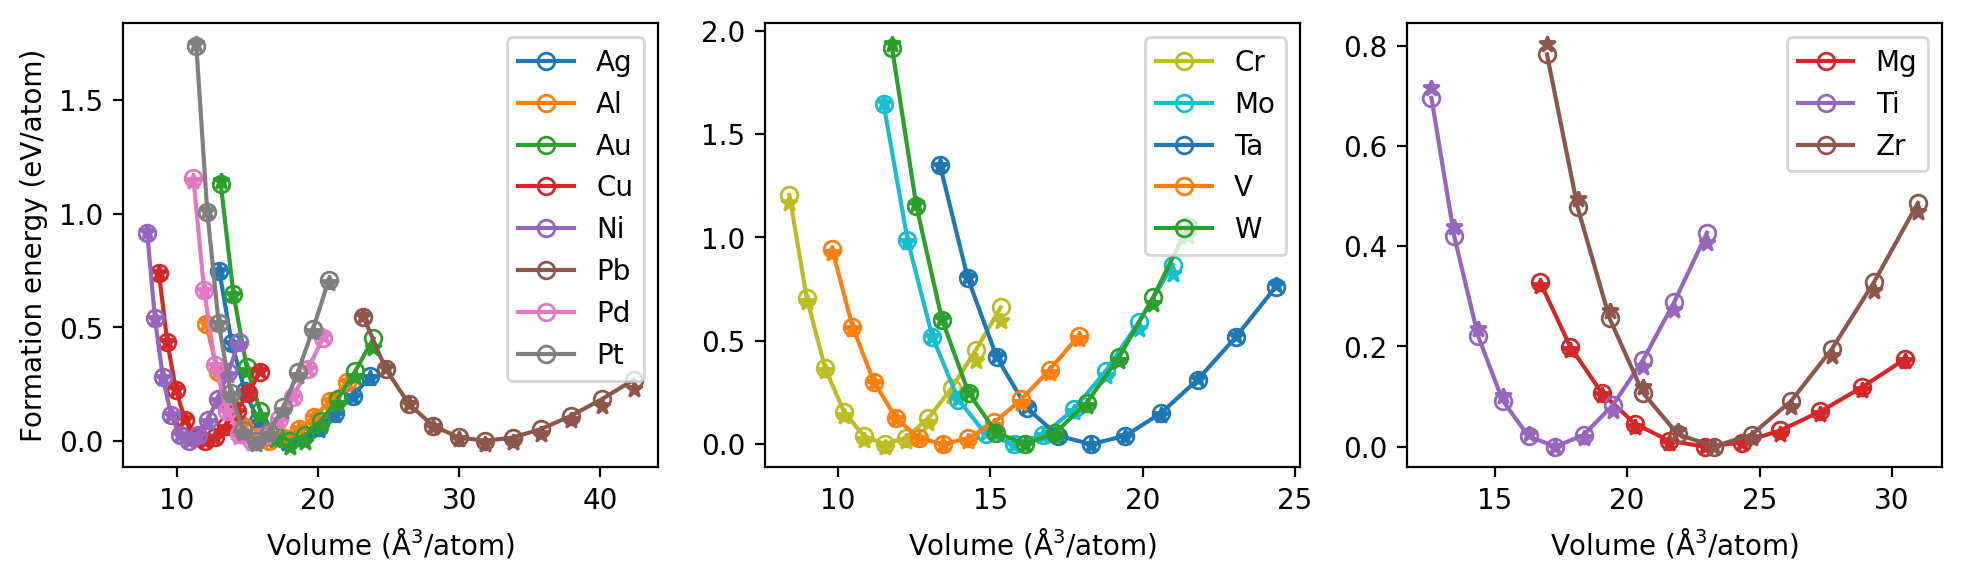

In [4]:
from matplotlib import pyplot as plt
from ase.data import chemical_symbols, reference_states
import json
%matplotlib inline

with open('data.json', 'r') as f:
     data = json.load(f)

crystal_structures = {s: r['symmetry'] if r is not None else None
                      for s, r in zip(chemical_symbols, reference_states)}
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 10
fig, axes = plt.subplots(
    figsize=(10, 3),
    dpi=200,
    ncols=3,
    sharex = False,
    sharey=False
)

for k, (species, values) in enumerate(data.items()):
    structure = crystal_structures[species]
    color = f'C{k}'
    if structure == 'fcc':
        axes[0].plot(values['volume'], values['NEP'], 'o-', color=color, label=species, fillstyle='none')
        axes[0].plot(values['volume'], values['DFT'], '*', color=color)
        axes[0].legend(loc = 'upper right')
        axes[0].set_xlabel('Volume (Å$^3$/atom)')
        axes[0].set_ylabel('Formation energy (eV/atom)')
    if structure == 'bcc':
        axes[1].plot(values['volume'], values['NEP'], 'o-', color=color, label=species, fillstyle='none')
        axes[1].plot(values['volume'], values['DFT'], '*', color=color)
        axes[1].legend(loc = 'upper right')
        axes[1].set_xlabel('Volume (Å$^3$/atom)')
        axes[0].set_ylabel('Formation energy (eV/atom)')
    if structure == 'hcp':
        axes[2].plot(values['volume'], values['NEP'], 'o-', color=color, label=species, fillstyle='none')
        axes[2].plot(values['volume'], values['DFT'], '*', color=color)
        axes[2].legend(loc = 'upper right')
        axes[2].set_xlabel('Volume (Å$^3$/atom)')
        axes[0].set_ylabel('Formation energy (eV/atom)')

fig.tight_layout()
fig.align_ylabels(axes)

plt.savefig('eos_curve.png')
plt.show()